In [ ]:
import cv2
import os
import numpy as np
import matplotlib.pyplot as plt
import tensorflow as tf
import tensorflow.keras as keras
from tensorflow.keras.preprocessing import image_dataset_from_directory

In [ ]:
PATH = "/content/drive/MyDrive/dataset/Covid19-dataset"

train_dir = os.path.join(PATH, 'train')
test_dir = os.path.join(PATH, 'test')
val_dir = os.path.join(PATH, 'valid')

In [ ]:
BATCH_SIZE = 32
IMG_SIZE = (224, 224)

train_dataset = image_dataset_from_directory(train_dir, shuffle=True, batch_size=BATCH_SIZE, image_size=IMG_SIZE)
valid_dataset = image_dataset_from_directory(val_dir, shuffle=True, batch_size=BATCH_SIZE, image_size=IMG_SIZE)
test_dataset = image_dataset_from_directory(test_dir, batch_size=BATCH_SIZE, image_size=IMG_SIZE)

Found 208 files belonging to 3 classes.
Found 49 files belonging to 3 classes.
Found 60 files belonging to 3 classes.


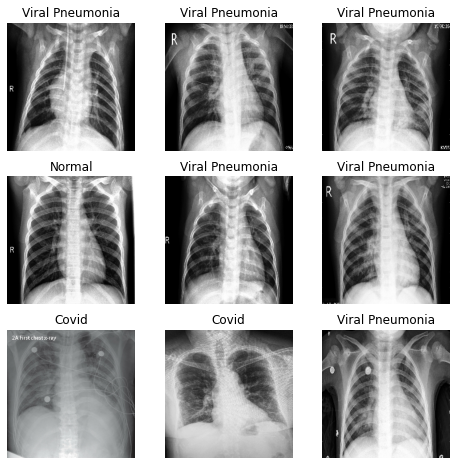

In [ ]:
class_names = train_dataset.class_names

plt.figure(figsize=(8, 8))
for images, labels in train_dataset.take(1):
  for i in range(9):
    ax = plt.subplot(3, 3, i + 1)
    plt.imshow(images[i].numpy().astype("uint8"))
    plt.title(class_names[labels[i]])
    plt.axis("off")

In [ ]:
print('Validation gruplarının sayısı : %d' % tf.data.experimental.cardinality(valid_dataset))
print('Test gruplarının sayısı: %d' % tf.data.experimental.cardinality(test_dataset))
print('Train gruplarının sayısı: %d' % tf.data.experimental.cardinality(train_dataset))

Validation gruplarının sayısı : 2
Test gruplarının sayısı: 2
Train gruplarının sayısı: 7


In [ ]:
data_augmentation = tf.keras.Sequential([
  tf.keras.layers.experimental.preprocessing.RandomFlip('horizontal'),
  tf.keras.layers.experimental.preprocessing.RandomRotation(0.03,),
  tf.keras.layers.GaussianNoise(0.3),
])

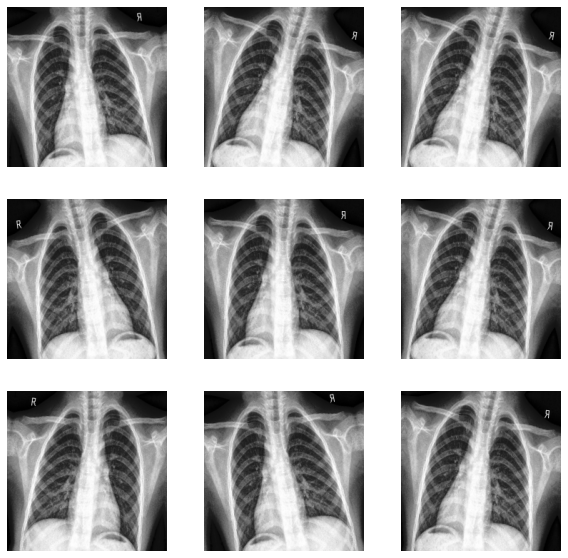

In [ ]:
for image, _ in train_dataset.take(1):
  plt.figure(figsize=(10, 10))
  first_image = image[0]
  for i in range(9):
    ax = plt.subplot(3, 3, i + 1)
    augmented_image = data_augmentation(tf.expand_dims(first_image, 0))
    plt.imshow(augmented_image[0] / 255)
    plt.axis('off')

In [ ]:
preprocess_input = tf.keras.applications.resnet50.preprocess_input

In [ ]:
preprocess_input

<function keras.applications.resnet.preprocess_input>

In [ ]:
rescale = tf.keras.layers.experimental.preprocessing.Rescaling(scale=1./255)

In [ ]:
rescale

In [ ]:
IMG_SHAPE = IMG_SIZE + (3,)
base_model = tf.keras.applications.ResNet50(input_shape=IMG_SHAPE,
                                               include_top=False,
                                               weights='imagenet')

94781440/94765736 [==============================] - 1s 0us/step


In [ ]:
image_batch, label_batch = next(iter(train_dataset))
feature_batch = base_model(image_batch)
print(feature_batch.shape)

(32, 7, 7, 2048)


In [ ]:
base_model.trainable = False

In [ ]:
base_model.summary()

Model: "resnet50"
__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
input_1 (InputLayer)            [(None, 224, 224, 3) 0                                            
__________________________________________________________________________________________________
conv1_pad (ZeroPadding2D)       (None, 230, 230, 3)  0           input_1[0][0]                    
__________________________________________________________________________________________________
conv1_conv (Conv2D)             (None, 112, 112, 64) 9472        conv1_pad[0][0]                  
__________________________________________________________________________________________________
conv1_bn (BatchNormalization)   (None, 112, 112, 64) 256         conv1_conv[0][0]                 
___________________________________________________________________________________________

In [ ]:
global_average_layer = tf.keras.layers.GlobalAveragePooling2D()
feature_batch_average = global_average_layer(feature_batch)
print(feature_batch_average.shape)

(32, 2048)


In [ ]:
prediction_layer = tf.keras.layers.Dense(3, activation='softmax')
prediction_batch = prediction_layer(feature_batch_average)
print(prediction_batch.shape)

(32, 3)


In [ ]:
inputs = tf.keras.Input(shape=IMG_SHAPE)
x = data_augmentation(inputs)
x = preprocess_input(x)
x = base_model(x, training=False)
x = global_average_layer(x)
x = tf.keras.layers.Dropout(0.2)(x)
outputs = prediction_layer(x)
model = tf.keras.Model(inputs, outputs)
model.summary()

Model: "model"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_2 (InputLayer)         [(None, 224, 224, 3)]     0         
_________________________________________________________________
sequential (Sequential)      (None, 224, 224, 3)       0         
_________________________________________________________________
tf.__operators__.getitem (Sl (None, 224, 224, 3)       0         
_________________________________________________________________
tf.nn.bias_add (TFOpLambda)  (None, 224, 224, 3)       0         
_________________________________________________________________
resnet50 (Functional)        (None, 7, 7, 2048)        23587712  
_________________________________________________________________
global_average_pooling2d (Gl (None, 2048)              0         
_________________________________________________________________
dropout (Dropout)            (None, 2048)              0     

In [ ]:
BASE_LEARNING_RATE = 0.001
model.compile(optimizer=tf.keras.optimizers.Adam(learning_rate=BASE_LEARNING_RATE),
              loss=tf.keras.losses.SparseCategoricalCrossentropy(from_logits=True),
              metrics=['accuracy'])

In [ ]:
INITIAL_EPOCHS = 50

history = model.fit(train_dataset,
                    epochs=INITIAL_EPOCHS,
                    validation_data=valid_dataset)

Epoch 1/50


/usr/local/lib/python3.7/dist-packages/keras/backend.py:4907: UserWarning: "`sparse_categorical_crossentropy` received `from_logits=True`, but the `output` argument was produced by a sigmoid or softmax activation and thus does not represent logits. Was this intended?"
  '"`sparse_categorical_crossentropy` received `from_logits=True`, but '


7/7 [==============================] - 53s 7s/step - loss: 1.2190 - accuracy: 0.4808 - val_loss: 0.6217 - val_accuracy: 0.8163
Epoch 2/50
7/7 [==============================] - 44s 6s/step - loss: 0.5990 - accuracy: 0.7596 - val_loss: 0.3951 - val_accuracy: 0.9184
Epoch 3/50
7/7 [==============================] - 44s 6s/step - loss: 0.4126 - accuracy: 0.8413 - val_loss: 0.3306 - val_accuracy: 0.8980
Epoch 4/50
7/7 [==============================] - 44s 6s/step - loss: 0.2743 - accuracy: 0.8990 - val_loss: 0.3202 - val_accuracy: 0.8980
Epoch 5/50
7/7 [==============================] - 44s 6s/step - loss: 0.2446 - accuracy: 0.9087 - val_loss: 0.3239 - val_accuracy: 0.8980
Epoch 6/50
7/7 [==============================] - 44s 6s/step - loss: 0.2107 - accuracy: 0.9038 - val_loss: 0.2848 - val_accuracy: 0.9184
Epoch 7/50
7/7 [==============================] - 44s 6s/step - loss: 0.1904 - accuracy: 0.9135 - val_loss: 0.3020 - val_accuracy: 0.8980
Epoch 8/50
7/7 [=============================

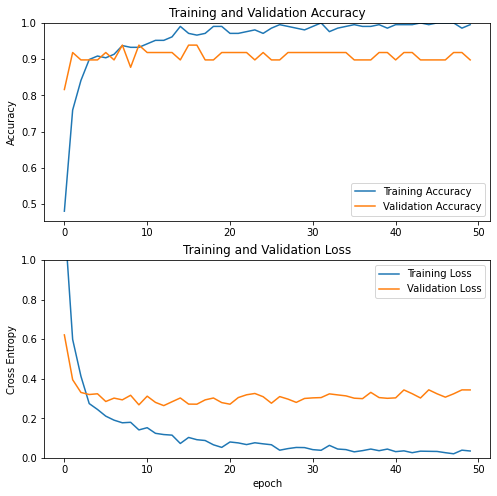

In [ ]:
acc = history.history['accuracy']
val_acc = history.history['val_accuracy']

loss = history.history['loss']
val_loss = history.history['val_loss']

plt.figure(figsize=(8, 8))
plt.subplot(2, 1, 1)
plt.plot(acc, label='Training Accuracy')
plt.plot(val_acc, label='Validation Accuracy')
plt.legend(loc='lower right')
plt.ylabel('Accuracy')
plt.ylim([min(plt.ylim()),1])
plt.title('Training and Validation Accuracy')

plt.subplot(2, 1, 2)
plt.plot(loss, label='Training Loss')
plt.plot(val_loss, label='Validation Loss')
plt.legend(loc='upper right')
plt.ylabel('Cross Entropy')
plt.ylim([0,1.0])
plt.title('Training and Validation Loss')
plt.xlabel('epoch')
plt.show()

Hata, 'categorical_crossentropy' bir sıcak kodlanmış hedef üzerinde çalışırken, 'sparse_categorical_crossentropy' tamsayı hedef üzerinde çalıştığı için ortaya çıktı.

In [ ]:
model.save("resnet50_transfer_learning.h5")
model.save("resnet50")

/usr/local/lib/python3.7/dist-packages/keras/utils/generic_utils.py:497: CustomMaskWarning: Custom mask layers require a config and must override get_config. When loading, the custom mask layer must be passed to the custom_objects argument.
  category=CustomMaskWarning)


INFO:tensorflow:Assets written to: resnet50/assets


/usr/local/lib/python3.7/dist-packages/keras/utils/generic_utils.py:497: CustomMaskWarning: Custom mask layers require a config and must override get_config. When loading, the custom mask layer must be passed to the custom_objects argument.
  category=CustomMaskWarning)


In [ ]:
new_model = keras.models.load_model("resnet50_transfer_learning.h5")
new_model.evaluate(test_dataset)

/usr/local/lib/python3.7/dist-packages/keras/backend.py:4907: UserWarning: "`sparse_categorical_crossentropy` received `from_logits=True`, but the `output` argument was produced by a sigmoid or softmax activation and thus does not represent logits. Was this intended?"
  '"`sparse_categorical_crossentropy` received `from_logits=True`, but '


7/7 [==============================] - 40s 5s/step - loss: 0.0237 - accuracy: 0.9904


[0.02370213158428669, 0.9903846383094788]

Predictions:
 [0 1 0 0 0 1 2 1 1 1 0 1 2 0 0 2 2 0 0 2 0 1 0 0 2 0 0 2 1 2 2 0]
Labels:
 [0 1 0 0 0 1 2 1 1 1 0 1 2 0 0 2 2 0 0 2 0 1 0 0 2 0 0 2 1 2 2 0]


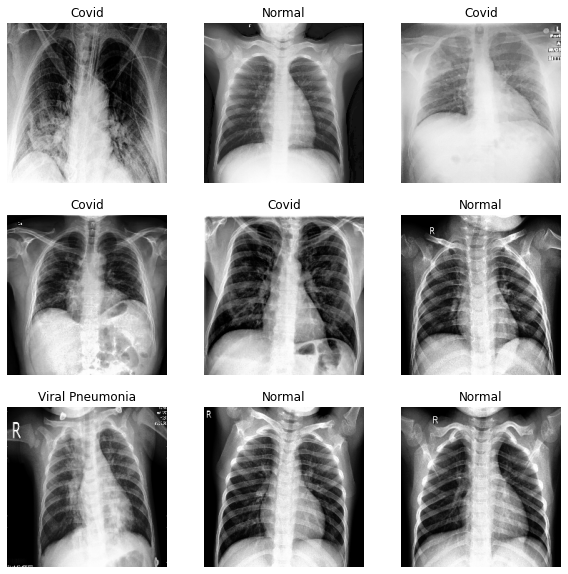

In [ ]:
image_batch, label_batch = test_dataset.as_numpy_iterator().next()
predictions = new_model.predict_on_batch(image_batch)

predictions = tf.nn.softmax(predictions)

prediction = []

for i in predictions:
  prediction.append(np.argmax(i))


print('Predictions:\n', np.asarray(prediction))
print('Labels:\n', label_batch)

plt.figure(figsize=(10, 10))
for i in range(9):
  ax = plt.subplot(3, 3, i + 1)
  plt.imshow(image_batch[i].astype("uint8"))
  plt.title(class_names[prediction[i]])
  plt.axis("off")

In [ ]:

new_model.save("resnet50")

INFO:tensorflow:Assets written to: resnet50/assets


/usr/local/lib/python3.7/dist-packages/keras/utils/generic_utils.py:497: CustomMaskWarning: Custom mask layers require a config and must override get_config. When loading, the custom mask layer must be passed to the custom_objects argument.
  category=CustomMaskWarning)


In [ ]:
import tensorflow as tf

saved_model_dir = "resnet50"

converter = tf.lite.TFLiteConverter.from_saved_model(saved_model_dir) 
tflite_model = converter.convert()

with open('model.tflite', 'wb') as f:
  f.write(tflite_model)

#load tensorflow lite model

tf lite modeli çalışıyor mu diye kodu hazır aldım

In [ ]:
tflite_interpreter = tf.lite.Interpreter(model_path="model.tflite")

input_details = tflite_interpreter.get_input_details()
output_details = tflite_interpreter.get_output_details()

print("== Input details ==")
print("name:", input_details[0]['name'])
print("shape:", input_details[0]['shape'])
print("type:", input_details[0]['dtype'])

print("\n== Output details ==")
print("name:", output_details[0]['name'])
print("shape:", output_details[0]['shape'])
print("type:", output_details[0]['dtype'])

== Input details ==
name: serving_default_input_2:0
shape: [  1 224 224   3]
type: <class 'numpy.float32'>

== Output details ==
name: StatefulPartitionedCall:0
shape: [1 3]
type: <class 'numpy.float32'>


In [ ]:
tflite_interpreter.resize_tensor_input(input_details[0]['index'], (32, 224, 224, 3))
tflite_interpreter.resize_tensor_input(output_details[0]['index'], (32, 3))
tflite_interpreter.allocate_tensors()

input_details = tflite_interpreter.get_input_details()
output_details = tflite_interpreter.get_output_details()

print("== Input details ==")
print("name:", input_details[0]['name'])
print("shape:", input_details[0]['shape'])
print("type:", input_details[0]['dtype'])

print("\n== Output details ==")
print("name:", output_details[0]['name'])
print("shape:", output_details[0]['shape'])
print("type:", output_details[0]['dtype'])

== Input details ==
name: serving_default_input_2:0
shape: [ 32 224 224   3]
type: <class 'numpy.float32'>

== Output details ==
name: StatefulPartitionedCall:0
shape: [32  3]
type: <class 'numpy.float32'>


In [ ]:
tflite_interpreter.set_tensor(input_details[0]['index'], image_batch)

tflite_interpreter.invoke()

tflite_model_predictions = tflite_interpreter.get_tensor(output_details[0]['index'])
print("Prediction results shape:", tflite_model_predictions.shape)

Prediction results shape: (32, 3)


In [ ]:
import pandas as pd

tflite_pred_dataframe = pd.DataFrame(tflite_model_predictions)
tflite_pred_dataframe.columns = class_names

print("TFLite prediction results for the first elements")
tflite_pred_dataframe.head()

TFLite prediction results for the first elements


,Covid,Normal,Viral Pneumonia
0,0.999324,2.917546e-04,0.000384
1,0.004820,8.467350e-01,0.148445
2,0.999966,3.482690e-07,0.000034
3,0.987139,1.238238e-02,0.000479
4,0.954515,4.061720e-02,0.004868


Predictions:
 [0 1 0 0 0 1 2 1 1 1 0 1 2 0 0 2 2 0 0 2 0 1 0 0 2 0 0 2 1 2 2 0]
Labels:
 [0 1 0 0 0 1 2 1 1 1 0 1 2 0 0 2 2 0 0 2 0 1 0 0 2 0 0 2 1 2 2 0]


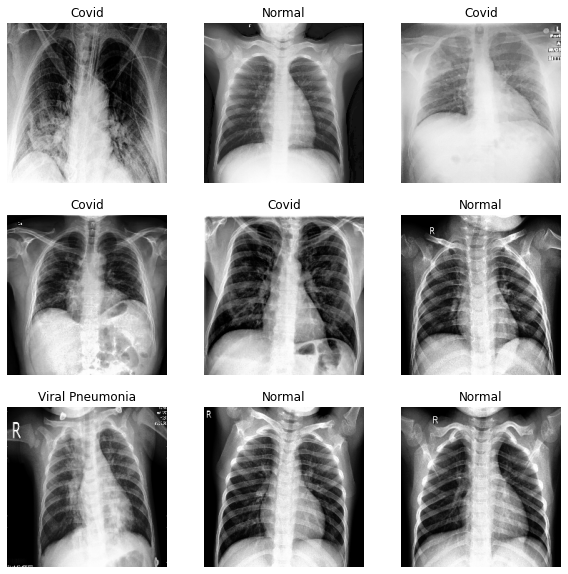

In [ ]:


tflite_model_predictions = tf.nn.softmax(tflite_model_predictions)

prediction = []

for i in tflite_model_predictions:
  prediction.append(np.argmax(i))


print('Predictions:\n', np.asarray(prediction))
print('Labels:\n', label_batch)

plt.figure(figsize=(10, 10))
for i in range(9):
  ax = plt.subplot(3, 3, i + 1)
  plt.imshow(image_batch[i].astype("uint8"))
  plt.title(class_names[prediction[i]])
  plt.axis("off")